<a href="https://colab.research.google.com/github/Surya-Hitesh-Nalam/captcha_solver/blob/main/captcha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import cv2
import os
import random
import json
import shutil
from pathlib import Path
from google.colab import drive
import zipfile
from google.colab import files

# --- CONFIGURATION ---
IMG_WIDTH = 128
IMG_HEIGHT = 32
MAX_LEN = 5
BATCH_SIZE = 64
EPOCHS = 50
ZIP_FILENAME = "text_based_captcha.zip"  # Must match your Drive file exactly

print("="*70)
print("🚀 SYSTEM START: CNN + ViT + BiLSTM (Drive Fast-Track)")
print(f"GPU Status: {'✅ Enabled' if len(tf.config.list_physical_devices('GPU')) > 0 else '❌ Disabled'}")
print("="*70)

# --- 1. GOOGLE DRIVE CONNECTION ---
if not os.path.exists('/content/drive'):
    print("🔌 Mounting Google Drive...")
    drive.mount('/content/drive')

drive_path = f"/content/drive/MyDrive/{ZIP_FILENAME}"
local_zip = f"/content/{ZIP_FILENAME}"
extract_path = "/content/data_extracted"

# --- 2. COPY & EXTRACT (One-time only per session) ---
if not os.path.exists(extract_path):
    print(f"\n⚡ Copying {ZIP_FILENAME} from Drive to Colab...")

    if not os.path.exists(drive_path):
        print(f"❌ ERROR: Could not find '{ZIP_FILENAME}' in your Google Drive.")
        print("   1. Go to drive.google.com")
        print("   2. Upload the zip file to the main 'My Drive' folder.")
        raise FileNotFoundError("Zip file missing from Google Drive.")

    shutil.copy(drive_path, local_zip)

    print("📂 Unzipping data...")
    with zipfile.ZipFile(local_zip, 'r') as z:
        z.extractall(extract_path)
    print("✅ Extraction Complete.")
else:
    print("⚡ Data already extracted. Skipping load step.")

# --- 3. PATH SETTING (Specific to your zip structure) ---
# You said the zip contains: temp_processed_output/ -> train, val, test
possible_roots = [
    os.path.join(extract_path, "temp_processed_output"),  # Priority 1
    os.path.join(extract_path, "text_based_captcha_v2", "temp_processed_output"), # Priority 2
    extract_path # Priority 3 (if they are at root)
]

BASE_DIR = None
print("\n🔍 Verifying dataset structure...")

for path in possible_roots:
    train_check = os.path.join(path, "train")
    if os.path.exists(train_check) and len(os.listdir(train_check)) > 0:
        BASE_DIR = path
        print(f"✅ Found valid dataset at: {BASE_DIR}")
        break

if BASE_DIR is None:
    # Fallback: Deep search if structure is different
    print("⚠️ Exact match not found. Searching recursively...")
    for root, dirs, files in os.walk(extract_path):
        if 'train' in dirs:
            # Check if it actually has images
            if len(os.listdir(os.path.join(root, 'train'))) > 0:
                BASE_DIR = root
                print(f"✅ Found dataset at: {BASE_DIR}")
                break

if BASE_DIR is None:
    raise ValueError("❌ CRITICAL ERROR: Could not find a 'train' folder with images inside the extracted zip.")

# --- 4. DATA LOADER ---
def add_augmentation(img):
    """Generates synthetic noise/lines to prevent overfitting"""
    if random.random() < 0.5:
        y1 = random.randint(0, IMG_HEIGHT)
        y2 = random.randint(0, IMG_HEIGHT)
        cv2.line(img, (0, y1), (IMG_WIDTH, y2), 0, 1)
    if random.random() < 0.3:
        img = cv2.GaussianBlur(img, (3, 3), 0)
    if len(img.shape) == 2:
        img = np.expand_dims(img, -1)
    return img

def load_data(folder, augment=False):
    path = Path(folder)
    # Support both png and jpg
    files_list = sorted(list(path.glob('*.png')) + list(path.glob('*.jpg')))
    images, labels, chars = [], [], set()

    print(f"   Processing {folder} ({len(files_list)} images)...")
    for f in files_list:
        img = cv2.imread(str(f), 0)
        if img is None: continue

        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = img / 255.0

        if augment:
            img = add_augmentation(img)

        img = np.expand_dims(img, -1)

        lbl = f.stem.lower().strip()
        if len(lbl) > MAX_LEN: lbl = lbl[:MAX_LEN]
        if len(lbl) < MAX_LEN: lbl = lbl.ljust(MAX_LEN, '_')

        images.append(img)
        labels.append(lbl)
        chars.update(lbl)

    return np.array(images), np.array(labels), sorted(list(chars))

print("\n📂 Loading Images into Memory...")
X_train, y_train_txt, c1 = load_data(os.path.join(BASE_DIR, 'train'), augment=True)
X_val, y_val_txt, c2 = load_data(os.path.join(BASE_DIR, 'val'), augment=False)
X_test, y_test_txt, c3 = load_data(os.path.join(BASE_DIR, 'test'), augment=False)

if len(X_train) == 0:
    raise ValueError("❌ Training set is empty! Check the path logic.")

# Build Vocabulary
all_chars = sorted(list(set(c1) | set(c2) | set(c3)))
if '_' not in all_chars: all_chars.append('_')
char_to_num = {c:i for i,c in enumerate(all_chars)}
num_to_char = {i:c for i,c in enumerate(all_chars)}
VOCAB_SIZE = len(all_chars)

print(f"✅ Vocabulary ({VOCAB_SIZE}): {''.join(all_chars)}")

def encode(labels):
    encoded = np.zeros((len(labels), MAX_LEN), dtype='int32')
    for i, lbl in enumerate(labels):
        for j, char in enumerate(lbl):
            encoded[i,j] = char_to_num.get(char, 0)
    return [encoded[:, i] for i in range(MAX_LEN)]

y_train = encode(y_train_txt)
y_val = encode(y_val_txt)

# --- 5. MODEL ARCHITECTURE ---
class ViTBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(ViTBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=True):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate
        })
        return config

def build_hybrid_model():
    input_img = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1), name="image")

    # CNN
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Reshape for Sequence
    x = layers.Permute((2, 1, 3))(x)
    x = layers.Reshape((16, 4 * 128))(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.1)(x)

    # ViT + Residual
    vit_out = ViTBlock(embed_dim=128, num_heads=4, ff_dim=256)(x)
    x = layers.Add()([x, vit_out])

    # BiLSTM
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = [layers.Dense(VOCAB_SIZE, activation="softmax", name=f"c{i}")(x) for i in range(MAX_LEN)]
    return keras.Model(inputs=input_img, outputs=outputs, name="CNN_ViT_BiLSTM_Residual")

model = build_hybrid_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']*MAX_LEN)

# --- 6. TRAINING ---
print("\n🎯 STARTING TRAINING...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
        keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-6)
    ]
)

# --- 7. EVALUATION ---
print("\n" + "="*70)
print("📊 EVALUATING ON TEST SET")
print("="*70)

test_preds = model.predict(X_test, verbose=1)

def decode_batch(preds):
    results = []
    for i in range(len(preds[0])):
        text = ""
        for j in range(MAX_LEN):
            idx = np.argmax(preds[j][i])
            char = num_to_char[idx]
            if char != '_': text += char
        results.append(text)
    return results

pred_texts = decode_batch(test_preds)

correct = 0
total = len(y_test_txt)

print(f"{'STATUS':<8} | {'TRUE':<10} | {'PRED':<10}")
print("-" * 35)

for i in range(total):
    true_txt = y_test_txt[i].replace('_', '')
    pred_txt = pred_texts[i]
    status = "✅" if true_txt == pred_txt else "❌"
    print(f"{status:<8} | {true_txt:<10} | {pred_txt:<10}")
    if true_txt == pred_txt: correct += 1

accuracy = (correct / total) * 100 if total > 0 else 0

print("\n" + "="*70)
print(f"🏆 FINAL ACCURACY: {accuracy:.2f}%")
print("="*70)

# Save
model.save('Final_Project_ViT.h5')
results = {
    'architecture': 'CNN + Vision Transformer + BiLSTM (Residual)',
    'test_accuracy': float(accuracy),
    'vocab_size': int(VOCAB_SIZE)
}
with open('final_results.json', 'w') as f:
    json.dump(results, f, indent=2)

files.download('final_results.json')

🚀 SYSTEM START: CNN + ViT + BiLSTM (Drive Fast-Track)
GPU Status: ✅ Enabled
⚡ Data already extracted. Skipping load step.

🔍 Verifying dataset structure...
✅ Found valid dataset at: /content/data_extracted/temp_processed_output

📂 Loading Images into Memory...
   Processing /content/data_extracted/temp_processed_output/train (57631 images)...
   Processing /content/data_extracted/temp_processed_output/val (12350 images)...
   Processing /content/data_extracted/temp_processed_output/test (12348 images)...
✅ Vocabulary (37): 0123456789abcdefghijklmnopqrstuvwxyz_

🎯 STARTING TRAINING...
Epoch 1/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 58s 52ms/step - c0_accuracy: 0.0561 - c0_loss: 3.4874 - c1_accuracy: 0.0499 - c1_loss: 3.5069 - c2_accuracy: 0.0475 - c2_loss: 3.5043 - c3_accuracy: 0.0504 - c3_loss: 3.5058 - c4_accuracy: 0.0510 - c4_loss: 3.4998 - loss: 17.5043 - val_c0_accuracy: 0.0762 - val_c0_loss: 3.8900 - val_c1_accuracy: 0.0672 - val_c1_loss: 3.7495 - val_c2_accuracy: 0.0517 - val_c2_loss: 3.

STATUS   | TRUE       | PRED      
-----------------------------------
✅        | 000t6      | 000t6     
✅        | 00151      | 00151     
✅        | 00179      | 00179     
✅        | 002rn      | 002rn     
✅        | 00340      | 00340     
✅        | 0036q      | 0036q     
✅        | 003z0      | 003z0     
✅        | 0056f      | 0056f     
✅        | 0058k      | 0058k     
✅        | 005y3      | 005y3     
✅        | 005yl      | 005yl     
✅        | 0066m      | 0066m     
✅        | 0068z      | 0068z     
✅        | 006ml      | 006ml     
✅        | 006y7      | 006y7     
✅        | 00757      | 00757     
✅        | 007ei      | 007ei     
✅        | 00800      | 00800     
❌        | 008a5      | o08a5     
✅        | 008j1      | 008j1     
✅        | 008j2      | 008j2     
❌        | 0098u      | oo98u     
✅        | 009j8      | 009j8     
✅        | 00bp0      | 00bp0     
✅        | 00j13      | 00j13     
❌        | 00j79      | 0oj79     
✅        | 00p0h   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📊 GENERATING COMPLETE PROJECT REPORT
📂 Created new folder: /content/drive/MyDrive/Captcha_Project_Analysis

🔍 Running predictions on Test Set...
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

🏆 Sequence Accuracy (Whole Captcha): 84.91%
🎯 Character Accuracy (Individual Letters): 96.68%
✅ Saved Curves: /content/drive/MyDrive/Captcha_Project_Analysis/training_curves.png


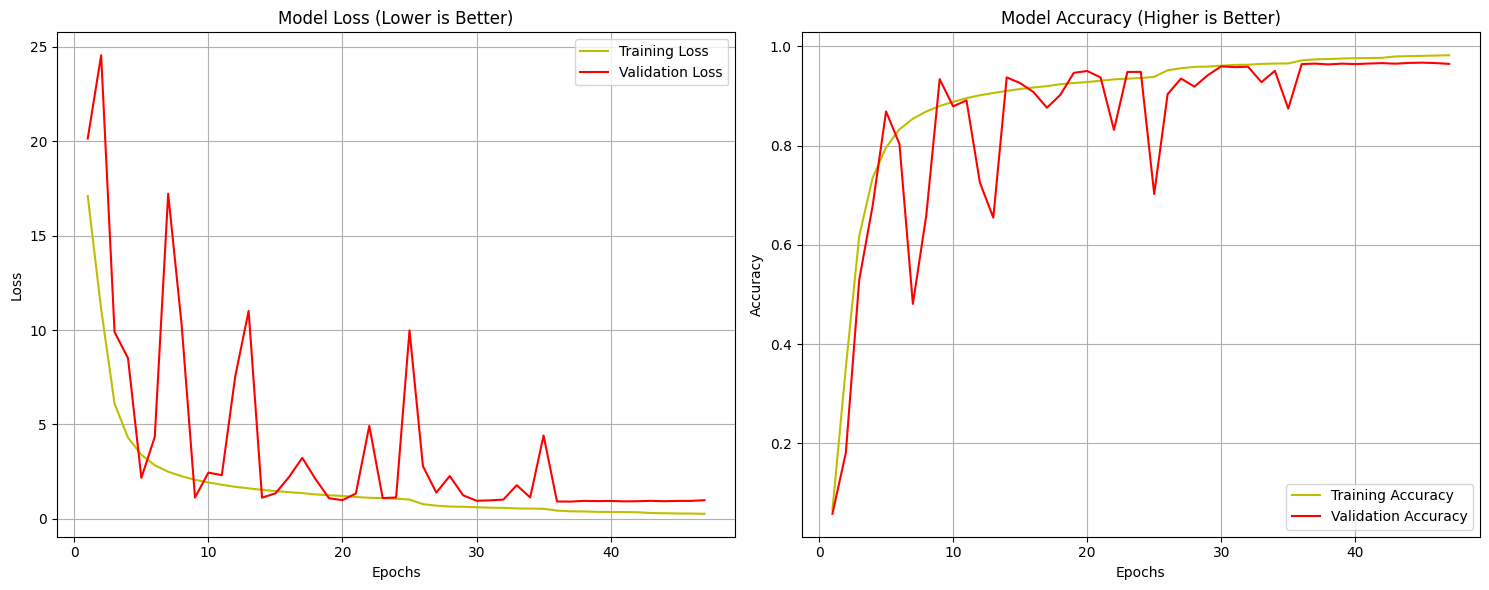


🎨 Generating Confusion Matrix...
✅ Saved Matrix: /content/drive/MyDrive/Captcha_Project_Analysis/confusion_matrix.png


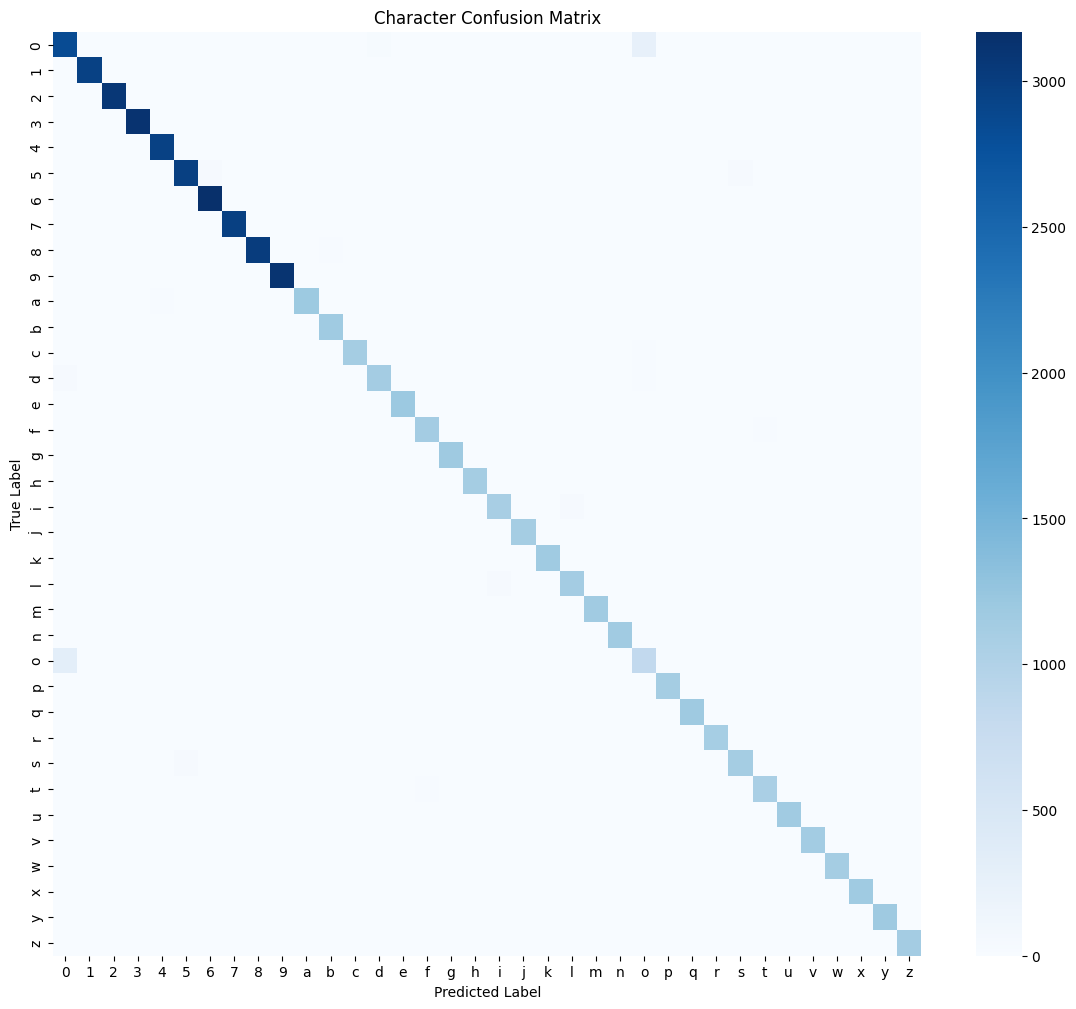


📝 Generating Classification Report...
✅ Saved Report: /content/drive/MyDrive/Captcha_Project_Analysis/classification_report.txt

🎉 DONE! All metrics saved to Drive folder: 'Captcha_Project_Analysis'


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import os

print("="*80)
print("📊 GENERATING COMPLETE PROJECT REPORT")
print("="*80)

# --- 1. SETUP DRIVE SAVE LOCATION ---
# We create a specific folder in your Drive to keep things organized
analysis_path = "/content/drive/MyDrive/Captcha_Project_Analysis"
if not os.path.exists(analysis_path):
    os.makedirs(analysis_path)
    print(f"📂 Created new folder: {analysis_path}")
else:
    print(f"📂 Saving to existing folder: {analysis_path}")

# --- 2. GENERATE PREDICTIONS ---
print("\n🔍 Running predictions on Test Set...")
# We use the X_test and y_test_txt variables from your training script
test_preds = model.predict(X_test, verbose=1)

# Helper to decode neural network output back to text
def decode_batch_predictions(preds):
    results = []
    for i in range(len(preds[0])):
        text = ""
        for j in range(MAX_LEN): # For each character position (0-4)
            # preds[j] is the array of probabilities for character j
            # preds[j][i] is the probability vector for image i
            idx = np.argmax(preds[j][i])
            char = num_to_char[idx]
            if char != '_': text += char
        results.append(text)
    return results

pred_texts = decode_batch_predictions(test_preds)

# --- 3. CALCULATE CORE METRICS ---
correct_sequences = 0
total_sequences = len(y_test_txt)
char_correct = 0
char_total = 0

y_true_chars = []
y_pred_chars = []

for i in range(total_sequences):
    true_txt = y_test_txt[i].replace('_', '')
    pred_txt = pred_texts[i]

    # Sequence Accuracy Check
    if true_txt == pred_txt:
        correct_sequences += 1

    # Character Accuracy Check
    # We compare up to the shortest length to avoid index errors
    min_len = min(len(true_txt), len(pred_txt))
    for j in range(min_len):
        char_total += 1
        y_true_chars.append(true_txt[j])
        y_pred_chars.append(pred_txt[j])
        if true_txt[j] == pred_txt[j]:
            char_correct += 1

    # Penalize length mismatch
    char_total += abs(len(true_txt) - len(pred_txt))

seq_acc = (correct_sequences / total_sequences) * 100
char_acc = (char_correct / char_total) * 100

print(f"\n🏆 Sequence Accuracy (Whole Captcha): {seq_acc:.2f}%")
print(f"🎯 Character Accuracy (Individual Letters): {char_acc:.2f}%")

# Save summary to text file
with open(f"{analysis_path}/summary_metrics.txt", "w") as f:
    f.write(f"FINAL PROJECT METRICS\n")
    f.write(f"=====================\n")
    f.write(f"Sequence Accuracy: {seq_acc:.2f}%\n")
    f.write(f"Character Accuracy: {char_acc:.2f}%\n")
    f.write(f"Total Test Images: {total_sequences}\n")

# --- 4. PLOT TRAINING CURVES (LOSS & ACCURACY) ---
# This graph proves your model actually learned over time
def plot_curves(history):
    # Extract data
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Average the accuracy across all 5 heads for a cleaner plot
    acc_keys = [k for k in history.history.keys() if 'accuracy' in k and 'val' not in k]
    val_acc_keys = [k for k in history.history.keys() if 'val' in k and 'accuracy' in k]

    avg_acc = np.mean([history.history[k] for k in acc_keys], axis=0)
    avg_val_acc = np.mean([history.history[k] for k in val_acc_keys], axis=0)

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(15, 6))

    # Subplot 1: Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'y-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Model Loss (Lower is Better)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Subplot 2: Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, avg_acc, 'y-', label='Training Accuracy')
    plt.plot(epochs, avg_val_acc, 'r-', label='Validation Accuracy')
    plt.title('Model Accuracy (Higher is Better)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    save_loc = f"{analysis_path}/training_curves.png"
    plt.savefig(save_loc)
    print(f"✅ Saved Curves: {save_loc}")
    plt.show()

if 'history' in locals():
    plot_curves(history)
else:
    print("⚠️ 'history' variable not found. Skipping curves.")

# --- 5. CONFUSION MATRIX (The "Deep Analysis" Chart) ---
# This heatmap shows exactly which letters get confused
print("\n🎨 Generating Confusion Matrix...")
unique_chars = sorted(list(set(y_true_chars + y_pred_chars)))

cm = confusion_matrix(y_true_chars, y_pred_chars, labels=unique_chars)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=unique_chars, yticklabels=unique_chars)
plt.title('Character Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
save_loc = f"{analysis_path}/confusion_matrix.png"
plt.savefig(save_loc)
print(f"✅ Saved Matrix: {save_loc}")
plt.show()

# --- 6. CLASSIFICATION REPORT (Detailed stats per letter) ---
print("\n📝 Generating Classification Report...")
report = classification_report(y_true_chars, y_pred_chars, zero_division=0)

with open(f"{analysis_path}/classification_report.txt", "w") as f:
    f.write(report)
print(f"✅ Saved Report: {analysis_path}/classification_report.txt")

print("\n" + "="*80)
print(f"🎉 DONE! All metrics saved to Drive folder: 'Captcha_Project_Analysis'")
print("="*80)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import cv2
import os
import random
import json
import shutil
import hashlib
from pathlib import Path
from google.colab import drive
import zipfile
from google.colab import files
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================
# CONFIGURATION
# ============================================
IMG_WIDTH = 128
IMG_HEIGHT = 32
MAX_LEN = 8  # Math equations are longer (e.g. "12+4=?")
BATCH_SIZE = 64
EPOCHS = 50
ZIP_FILENAME = "math_captcha_dataset.zip"

print("="*80)
print("🚀 PRO MODEL: MATH SOLVER EDITION")
print("   - Task: OCR + Mathematical Evaluation")
print("   - Output: The calculated answer (e.g., '2+2' -> '4')")
print("="*80)

# ============================================
# 1. SETUP & DRIVE
# ============================================
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

drive_path = f"/content/drive/MyDrive/{ZIP_FILENAME}"
extract_path = "/content/math_data_root"

if not os.path.exists(extract_path):
    print(f"⚡ Copying {ZIP_FILENAME}...")
    if not os.path.exists(drive_path):
         raise FileNotFoundError(f"❌ '{ZIP_FILENAME}' not found in Google Drive!")

    with zipfile.ZipFile(drive_path, 'r') as z:
        z.extractall(extract_path)
    print("✅ Extraction Complete.")
else:
    print("⚡ Data already extracted.")

# ============================================
# 2. LOCATE DATA
# ============================================
possible_roots = [
    os.path.join(extract_path, "math_captcha"),
    extract_path
]

BASE_DIR = None
for path in possible_roots:
    if os.path.exists(os.path.join(path, "train")):
        BASE_DIR = path
        break

if BASE_DIR is None:
    for root, dirs, files in os.walk(extract_path):
        if 'train' in dirs:
            BASE_DIR = root
            break

if BASE_DIR is None:
    raise ValueError("❌ Could not find 'train' folder for Math dataset.")

print(f"✅ Found dataset at: {BASE_DIR}")

# ============================================
# 3. SANITIZER
# ============================================
def clean_dataset(folder):
    print(f"🔍 Cleaning {folder}...")
    unique_hashes = set()
    removed = 0
    path_obj = Path(folder)
    files = list(path_obj.glob('**/*.png')) + list(path_obj.glob('**/*.jpg'))

    for f in files:
        if os.path.getsize(f) == 0:
            os.remove(f)
            removed += 1
            continue
        try:
            with open(f, "rb") as f_obj:
                file_hash = hashlib.md5(f_obj.read()).hexdigest()
            if file_hash in unique_hashes:
                os.remove(f)
                removed += 1
            else:
                unique_hashes.add(file_hash)
        except:
            if os.path.exists(f): os.remove(f)
            removed += 1
    print(f"   ✅ Cleaned {removed} files.")

clean_dataset(os.path.join(BASE_DIR, 'train'))
clean_dataset(os.path.join(BASE_DIR, 'val'))
clean_dataset(os.path.join(BASE_DIR, 'test'))

# ============================================
# 4. DATA LOADING
# ============================================
def load_math_data(folder):
    path = Path(folder)
    files = sorted(list(path.glob('**/*.png')) + list(path.glob('**/*.jpg')))
    images, labels, chars = [], [], set()

    print(f"   Loading {len(files)} images from {folder}...")
    for f in files:
        try:
            img = cv2.imread(str(f), 0)
            if img is None: continue

            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            img = img / 255.0
            img = np.expand_dims(img, -1)

            lbl = f.stem
            if len(lbl) > MAX_LEN: lbl = lbl[:MAX_LEN]
            if len(lbl) < MAX_LEN: lbl = lbl.ljust(MAX_LEN, '_')

            images.append(img)
            labels.append(lbl)
            chars.update(lbl)
        except:
            continue

    return np.array(images), np.array(labels), sorted(list(chars))

print("\n📂 Loading Math Data...")
X_train, y_train_txt, c1 = load_math_data(os.path.join(BASE_DIR, 'train'))
X_val, y_val_txt, c2 = load_math_data(os.path.join(BASE_DIR, 'val'))
X_test, y_test_txt, c3 = load_math_data(os.path.join(BASE_DIR, 'test'))

all_chars = sorted(list(set(c1) | set(c2) | set(c3)))
if '_' not in all_chars: all_chars.append('_')
char_to_num = {c:i for i,c in enumerate(all_chars)}
num_to_char = {i:c for i,c in enumerate(all_chars)}
VOCAB_SIZE = len(all_chars)
print(f"✅ Vocabulary: {''.join(all_chars)}")

def encode(labels):
    encoded = np.zeros((len(labels), MAX_LEN), dtype='int32')
    for i, lbl in enumerate(labels):
        for j, char in enumerate(lbl):
            encoded[i,j] = char_to_num.get(char, 0)
    return [encoded[:, i] for i in range(MAX_LEN)]

y_train = encode(y_train_txt)
y_val = encode(y_val_txt)

# ============================================
# 5. UNIFIED PRO MODEL
# ============================================
class ViTBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(ViTBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=True):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update({"embed_dim": self.embed_dim, "num_heads": self.num_heads, "ff_dim": self.ff_dim, "rate": self.rate})
        return config

def build_pro_model():
    input_img = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1), name="image")

    # 1. Deep CNN
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.1)(x)

    # Reshape
    x = layers.Permute((2, 1, 3))(x)
    target_width = x.shape[1]
    target_channels = x.shape[2] * x.shape[3]
    x = layers.Reshape((target_width, target_channels))(x)
    x = layers.Dense(128, activation="relu")(x)

    # 2. Stacked ViT
    vit_out1 = ViTBlock(embed_dim=128, num_heads=8, ff_dim=256)(x)
    x = layers.Add()([x, vit_out1])

    vit_out2 = ViTBlock(embed_dim=128, num_heads=8, ff_dim=256)(x)
    x = layers.Add()([x, vit_out2])

    # 3. BiLSTM
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.3))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3))(x)

    # 4. Heads (Increased dropout for Math)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = [layers.Dense(VOCAB_SIZE, activation="softmax", name=f"c{i}")(x) for i in range(MAX_LEN)]
    return keras.Model(inputs=input_img, outputs=outputs, name="Pro_Model_Generalization")

print("\n🏗️ Building Unified PRO Model...")
model = build_pro_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'] * MAX_LEN)

# ============================================
# 6. TRAINING
# ============================================
print("\n🎯 STARTING TRAINING...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor='val_loss'),
        keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-6)
    ]
)

# ============================================
# 7. EVALUATION (UPDATED FOR MATH SOLVING)
# ============================================
print("\n" + "="*80)
print("📊 EVALUATING MATH CAPTCHA SOLUTIONS")
print("="*80)

test_preds = model.predict(X_test, verbose=1)

def decode_and_solve(preds):
    decoded_text = []
    solutions = []

    for i in range(len(preds[0])):
        # 1. Decode Text
        text = ""
        for j in range(MAX_LEN):
            idx = np.argmax(preds[j][i])
            char = num_to_char[idx]
            if char != '_': text += char
        decoded_text.append(text)

        # 2. Solve Equation
        try:
            # Clean up (handle X as *, remove =, remove ?)
            clean_eq = text.lower().replace('=', '').replace('?', '').replace('x', '*')
            # Security check: only allow digits and math ops
            if set(clean_eq).issubset(set("0123456789+-*/. ")):
                if clean_eq.strip() == "":
                    ans = "Empty"
                else:
                    ans = str(round(eval(clean_eq), 2)) # Evaluate and round
            else:
                ans = "InvalidChar"
        except:
            ans = "Error"
        solutions.append(ans)

    return decoded_text, solutions

pred_texts, pred_answers = decode_and_solve(test_preds)

# --- CALCULATE SCORES ---
correct_ocr = 0    # Text matched exactly
correct_math = 0   # Answer matched exactly
total = len(y_test_txt)

print(f"\n{'IMAGE TEXT':<15} | {'PREDICTED':<15} | {'CALC ANS':<10} | {'STATUS'}")
print("-" * 60)

for i in range(total):
    true_txt = y_test_txt[i].replace('_', '')
    pred_txt = pred_texts[i]
    pred_ans = pred_answers[i]

    # Calculate True Answer for comparison
    try:
        clean_true = true_txt.lower().replace('=', '').replace('?', '').replace('x', '*')
        true_ans = str(round(eval(clean_true), 2))
    except:
        true_ans = "???"

    # Check matches
    ocr_match = (true_txt == pred_txt)
    math_match = (true_ans == pred_ans)

    if ocr_match: correct_ocr += 1
    if math_match: correct_math += 1

    # Print sample
    if i < 20:
        status = "✅" if math_match else "❌"
        print(f"{true_txt:<15} | {pred_txt:<15} | {pred_ans:<10} | {status}")

ocr_acc = (correct_ocr / total) * 100
math_acc = (correct_math / total) * 100

print("\n" + "="*80)
print(f"🏆 OCR ACCURACY (Reading):  {ocr_acc:.2f}%")
print(f"🧮 MATH ACCURACY (Solving): {math_acc:.2f}%")
print("="*80)

# Save Metrics
with open("math_results.txt", "w") as f:
    f.write(f"OCR Accuracy: {ocr_acc:.2f}%\n")
    f.write(f"Math Accuracy: {math_acc:.2f}%\n")

model.save('Unified_Pro_Model_Math.h5')
files.download('Unified_Pro_Model_Math.h5')
files.download('math_results.txt')

🚀 PRO MODEL: MATH SOLVER EDITION
   - Task: OCR + Mathematical Evaluation
   - Output: The calculated answer (e.g., '2+2' -> '4')
Mounted at /content/drive
⚡ Copying math_captcha_dataset.zip...
✅ Extraction Complete.
✅ Found dataset at: /content/math_data_root/math_captcha
🔍 Cleaning /content/math_data_root/math_captcha/train...
   ✅ Cleaned 0 files.
🔍 Cleaning /content/math_data_root/math_captcha/val...
   ✅ Cleaned 0 files.
🔍 Cleaning /content/math_data_root/math_captcha/test...
   ✅ Cleaned 0 files.

📂 Loading Math Data...
   Loading 11334 images from /content/math_data_root/math_captcha/train...
   Loading 2428 images from /content/math_data_root/math_captcha/val...
   Loading 2430 images from /content/math_data_root/math_captcha/test...
✅ Vocabulary: +-0123456789_

🏗️ Building Unified PRO Model...

🎯 STARTING TRAINING...
Epoch 1/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 38s 103ms/step - c0_accuracy: 0.3944 - c0_loss: 2.0177 - c1_accuracy: 0.1250 - c1_loss: 2.4983 - c2_accuracy: 0.3086 - c2_


IMAGE TEXT      | PREDICTED       | CALC ANS   | STATUS
------------------------------------------------------------
0+117           | 0+117           | 117        | ✅
0+127           | 0+127           | 127        | ✅
0+144           | 0+144           | 144        | ✅
0+30            | 0+30            | 30         | ✅
0+65            | 0+65            | 65         | ✅
0+82            | 0+82            | 82         | ✅
0+88            | 0+88            | 88         | ✅
0+92            | 0+92            | 92         | ✅
0-105           | 0-105           | -105       | ✅
0-112           | 0-112           | -112       | ✅
0-74            | 0-74            | -74        | ✅
0-90            | 0-90            | -90        | ✅
1+112           | 1+112           | 113        | ✅
1+122           | 1+122           | 123        | ✅
1+22            | 1+22            | 23         | ✅
1+39            | 1+39            | 40         | ✅
1+40            | 1+40            | 41         | ✅
1+54           

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📊 GENERATING MATH PROJECT REPORT (DRIVE EXPORT)
📂 Created new folder: /content/drive/MyDrive/Math_Captcha_Analysis

🔍 Running predictions on Test Set...
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

🏆 OCR Accuracy (Text):     97.70%
🧮 Math Accuracy (Logic):   97.74%
🎯 Character Accuracy:      99.53%
✅ Saved Error Log: /content/drive/MyDrive/Math_Captcha_Analysis/error_analysis_log.txt
✅ Saved Curves: /content/drive/MyDrive/Math_Captcha_Analysis/training_curves.png


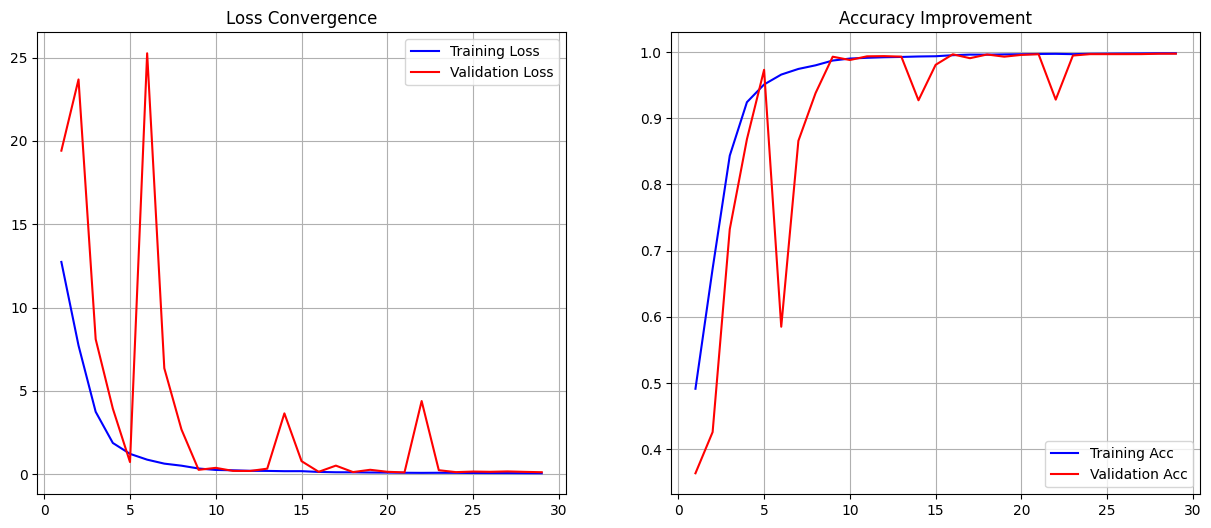


🎨 Generating Confusion Matrix...
✅ Saved Matrix: /content/drive/MyDrive/Math_Captcha_Analysis/confusion_matrix.png


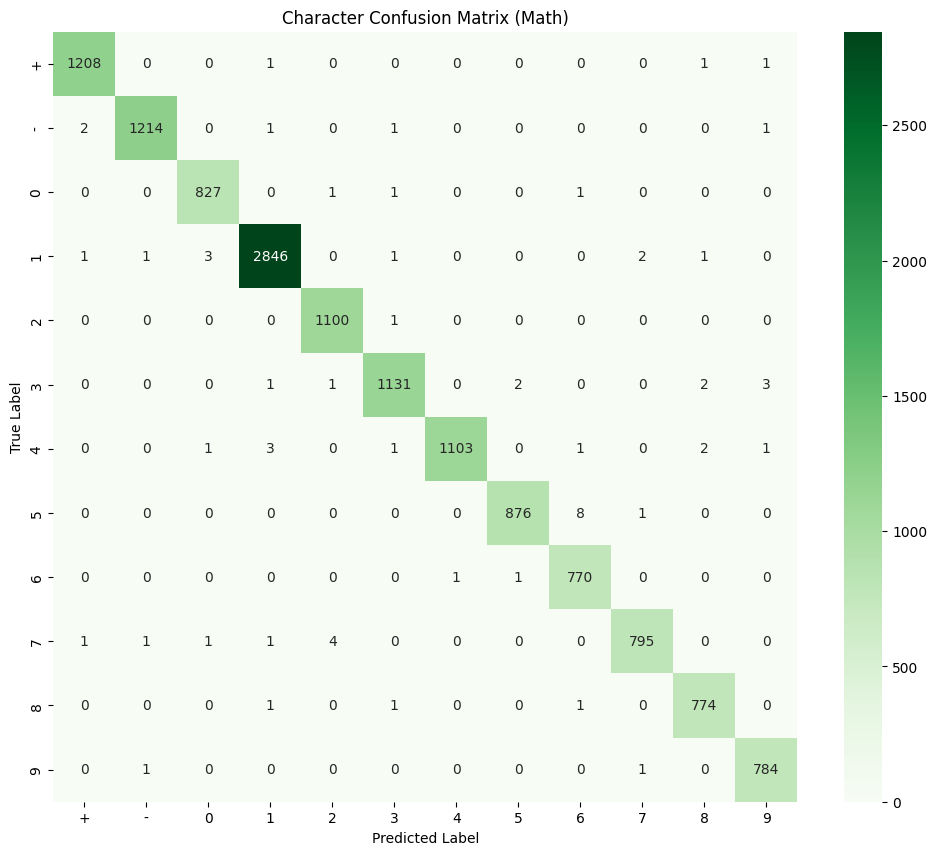


🎉 REPORT GENERATION COMPLETE


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import os
import numpy as np

print("="*80)
print("📊 GENERATING MATH PROJECT REPORT (DRIVE EXPORT)")
print("="*80)

# --- 1. SETUP DRIVE SAVE LOCATION ---
analysis_path = "/content/drive/MyDrive/Math_Captcha_Analysis"
if not os.path.exists(analysis_path):
    os.makedirs(analysis_path)
    print(f"📂 Created new folder: {analysis_path}")
else:
    print(f"📂 Saving to existing folder: {analysis_path}")

# --- 2. GENERATE PREDICTIONS ---
print("\n🔍 Running predictions on Test Set...")
test_preds = model.predict(X_test, verbose=1)

def decode_and_solve_batch(preds):
    decoded_text = []
    solutions = []
    for i in range(len(preds[0])):
        # 1. Decode Text
        text = ""
        for j in range(MAX_LEN):
            idx = np.argmax(preds[j][i])
            char = num_to_char[idx]
            if char != '_': text += char
        decoded_text.append(text)

        # 2. Solve (Safe Eval)
        try:
            clean_eq = text.lower().replace('=', '').replace('?', '').replace('x', '*')
            if set(clean_eq).issubset(set("0123456789+-*/. ")):
                if clean_eq.strip() == "": ans = "Empty"
                else: ans = str(round(eval(clean_eq), 2))
            else: ans = "InvalidChar"
        except: ans = "Error"
        solutions.append(ans)
    return decoded_text, solutions

pred_texts, pred_answers = decode_and_solve_batch(test_preds)

# --- 3. CALCULATE METRICS ---
y_true_chars = []
y_pred_chars = []
failures = [] # To store images where it failed

correct_ocr = 0
correct_math = 0
total = len(y_test_txt)

for i in range(total):
    true_txt = y_test_txt[i].replace('_', '')
    pred_txt = pred_texts[i]
    pred_ans = pred_answers[i]

    # Calculate True Answer
    try:
        clean_true = true_txt.lower().replace('=', '').replace('?', '').replace('x', '*')
        true_ans = str(round(eval(clean_true), 2))
    except: true_ans = "???"

    # OCR Accuracy (Exact text match)
    if true_txt == pred_txt:
        correct_ocr += 1

    # Math Accuracy (Answer match)
    # We compare answer strings. "4.0" == "4.0"
    if true_ans == pred_ans:
        correct_math += 1
    else:
        # Log failure
        failures.append(f"Image {i}: True='{true_txt}' ({true_ans}) | Pred='{pred_txt}' ({pred_ans})")

    # Character Collection for Confusion Matrix
    min_len = min(len(true_txt), len(pred_txt))
    for j in range(min_len):
        y_true_chars.append(true_txt[j])
        y_pred_chars.append(pred_txt[j])

ocr_acc = (correct_ocr / total) * 100
math_acc = (correct_math / total) * 100
char_acc = np.mean(np.array(y_true_chars) == np.array(y_pred_chars)) * 100

print(f"\n🏆 OCR Accuracy (Text):     {ocr_acc:.2f}%")
print(f"🧮 Math Accuracy (Logic):   {math_acc:.2f}%")
print(f"🎯 Character Accuracy:      {char_acc:.2f}%")

# Save summary
with open(f"{analysis_path}/final_metrics_summary.txt", "w") as f:
    f.write("MATH CAPTCHA PROJECT METRICS\n============================\n")
    f.write(f"Solution Accuracy: {math_acc:.2f}% (Main Metric)\n")
    f.write(f"Sequence Accuracy: {ocr_acc:.2f}%\n")
    f.write(f"Character Accuracy: {char_acc:.2f}%\n")

# Save Error Log (Crucial for report "Error Analysis" section)
with open(f"{analysis_path}/error_analysis_log.txt", "w") as f:
    f.write("\n".join(failures))
print(f"✅ Saved Error Log: {analysis_path}/error_analysis_log.txt")

# --- 4. PLOT CURVES ---
def plot_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Average accuracy across heads
    acc_keys = [k for k in history.history.keys() if 'accuracy' in k and 'val' not in k]
    val_acc_keys = [k for k in history.history.keys() if 'accuracy' in k and 'val' in k]
    avg_acc = np.mean([history.history[k] for k in acc_keys], axis=0)
    avg_val_acc = np.mean([history.history[k] for k in val_acc_keys], axis=0)

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Loss Convergence')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, avg_acc, 'b-', label='Training Acc')
    plt.plot(epochs, avg_val_acc, 'r-', label='Validation Acc')
    plt.title('Accuracy Improvement')
    plt.legend()
    plt.grid(True)

    plt.savefig(f"{analysis_path}/training_curves.png")
    print(f"✅ Saved Curves: {analysis_path}/training_curves.png")
    plt.show()

if 'history' in locals(): plot_curves(history)
else: print("⚠️ History object lost (cannot plot curves).")

# --- 5. CONFUSION MATRIX ---
print("\n🎨 Generating Confusion Matrix...")
unique_chars = sorted(list(set(y_true_chars + y_pred_chars)))
cm = confusion_matrix(y_true_chars, y_pred_chars, labels=unique_chars)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=unique_chars, yticklabels=unique_chars)
plt.title('Character Confusion Matrix (Math)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(f"{analysis_path}/confusion_matrix.png")
print(f"✅ Saved Matrix: {analysis_path}/confusion_matrix.png")
plt.show()

print("\n" + "="*80)
print("🎉 REPORT GENERATION COMPLETE")
print("="*80)